In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import matrix, solvers

# Build Soccer Game Enviornment

In [2]:
class soccer_game():
    
    def _generate_states_hash(self, rows, columns):
        grid = rows * columns
        states_hash = {}
        states_index = 0
        for i in range(grid):
            grid_list = range(grid)
            del grid_list[i]
            for j in grid_list:
                for k in range(2):
                    states_hash[(i,j,k)] = states_index
                    states_index += 1
        print("Observation space: ", len(states_hash))
        return states_hash
                
    def __init__(self, playerA, playerB):
        self.playerA = playerA
        self.playerB = playerB
        self.rows = 2
        self.columns = 4
        self.observation_space = self.rows * self.columns *(self.rows * self.columns - 1) * 2
        self.action_space = 5
  
        # Game Grid
        #       column
        #      0  1  2  3
        # row  4  5  6  7
        self.playerA_goal = [0, 4]
        self.playerB_goal = [3, 7]
        self.ball = np.random.randint(2)
        self.states_hash = self._generate_states_hash(self.rows, self.columns)
    
    def _reset(self):
        # Reset to the configuration show in Figure 4
        playerA.pos = 2
        playerB.pos = 1
        self.ball = 1 # Player B has the ball
    
    def new_game(self):
        
        starting_positions = [1, 2, 5, 6]
        random_int = np.random.choice(len(starting_positions), 2, replace=False)
        playerA.pos = starting_positions[random_int[0]]
        playerB.pos = starting_positions[random_int[1]]
        
        if np.random.randint(2) == 0:
            self.ball = 0
        else:
            self.ball = 1
      
    def _actions(self, player, action):
        
        # 0: North, 1: South, 2: East 3: West 4: Stick
        player_next_location = player.pos
        
        # Go North
        if action == 0 and (player.pos > 3):
            player_next_location = player.pos - 4
        # Go South
        if action == 1 and (player.pos < 4):
            player_next_location = player.pos + 4
        # Go East    
        if action == 2 and (player.pos not in self.playerB_goal):
            player_next_location = player.pos + 1
        # Go West
        if action == 3 and (player.pos not in self.playerA_goal):
            player_next_location = player.pos - 1
        # Stick
        if action == 4:
            player_next_location = player.pos
        # Unknown actions
        if action not in range(self.action_space):
            print("Something wrong: Unknown Action! Action is: ", action)
        
        return player_next_location
    
    def _move(self, player1, player2, action1, action2):
        
        player1_temp_loc = self._actions(player1, action1)
        player2_temp_loc = self._actions(player2, action2)
        
        # Always set player1 to move first
        # If next step's destination was not occupied
        if player1_temp_loc != player2.pos:
            player1.pos = player1_temp_loc
        
        # next step's destination was occupied, player1 is playerA and has the ball
        if (player1_temp_loc == player2.pos) and (player1.name == "A") and (self.ball == 0):
            self.ball == 1 # transfer the ball from A to B
        
        # next step's destination was occupied, player1 is playerB and has the ball
        if (player1_temp_loc == player2.pos) and (player1.name == "B") and (self.ball == 1):
            self.ball == 0 # transfer the ball from B to A
        
        # Now player2 move
        # If next step's destination was not occupied
        if player2_temp_loc != player1.pos:
            player2.pos = player2_temp_loc
        
        # next step's destination was occupied, player2 is playerA and has the ball
        if (player2_temp_loc == player1.pos) and (player2.name == "A") and (self.ball == 0):
            self.ball == 1 # transfer the ball from A to B
        
        # playerq is playerB and has the ball
        if (player2_temp_loc == player1.pos) and (player2.name == "B") and (self.ball == 1):
            self.ball == 0 # transfer the ball from B to A
    
    def _step(self, playerA, playerB, actionA, actionB):
        
        rewardA = 0
        rewardB = 0
        done    = 0
        
        # Random order of playerA and playerB actions
        if np.random.randint(2) == 0:
            self._move(playerA, playerB, actionA, actionB)
        else:
            self._move(playerB, playerA, actionB, actionA)
        
        # A in A'goal region with ball
        if (playerA.pos in self.playerA_goal) and (self.ball == 0):
            rewardA = 100
            rewardB = -100
            done = 1
        
        # A in B'goal region with ball
        if (playerA.pos in self.playerB_goal) and (self.ball == 0):
            rewardA = -100
            rewardB = 100
            done = 1
            
        # B in B'goal region with ball
        if (playerB.pos in self.playerB_goal) and (self.ball == 1):
            rewardA = -100
            rewardB = 100
            done = 1
        
        # B in A'goal region with ball
        if (playerB.pos in self.playerA_goal) and (self.ball == 1):
            rewardA = 100
            rewardB = -100
            done = 1
            
        return (playerA.pos, playerB.pos, self.ball), rewardA, rewardB, done

# Build Soccer Game Agents

In [3]:
class player():

    def __init__(self, name="A"):
        self.name = name
        self.pos = 0

# Making Figures

In [4]:
def _graph(Q_error, iteration, title, linewidth):
    
    plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.set_ylim([0,0.5])
    
    SMALL_SIZE = 16
    MEDIUM_SIZE = 22
    BIGGER_SIZE = 24
    
    plt.rc('font', size=MEDIUM_SIZE)          
    plt.rc('axes', titlesize=MEDIUM_SIZE)     
    plt.rc('axes', labelsize=MEDIUM_SIZE)     
    plt.rc('xtick', labelsize=SMALL_SIZE)    
    plt.rc('ytick', labelsize=SMALL_SIZE)    
    plt.rc('legend', fontsize=MEDIUM_SIZE)    
    plt.rc('figure', titlesize=BIGGER_SIZE)  
   
    plt.plot(iteration, Q_error, linewidth = linewidth)
    plt.xticks(np.arange(0, 10**6+1, 10**5))
    plt.yticks(np.arange(0, 0.5+0.001, 0.05))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
    plt.title(title)
    plt.xlabel('Simulation Iteration')
    plt.ylabel('Q-Value Difference')
    plt.show()
    plt.gcf().clear()

# Q-learning

In [5]:
def _Q_learning(GAME, playerA, playerB, iterations, epsilonMAX, epsilonMIN, alphaMAX, alphaMIN, gamma):
    
    epsilon_decay = (epsilonMAX - epsilonMIN) / iterations
    alpha_decay = 0.999993
    
    alpha = alphaMAX
    epsilon = epsilonMAX
    
    # Make Q-table
    Q_playerA = np.zeros([GAME.observation_space, GAME.action_space])
    Q_playerB = np.zeros([GAME.observation_space, GAME.action_space])
    
    GAME._reset()
    done = 0

    Q_error_list = []
    iteration_list = []
    
    for iteration in range(iterations):
        
        if done == 1:
            GAME._reset()
            done = 0
        
        current_state_index = GAME.states_hash[(playerA.pos, playerB.pos, GAME.ball)] 
        initial_state_index = GAME.states_hash[(2, 1, 1)] 
        old_Q_value = Q_playerA[initial_state_index, 1] # State s in Figure4, take action S
        
        # Epsilon-greedy search
        if epsilon > np.random.random():
            actionA = np.random.choice(GAME.action_space)
            actionB = np.random.choice(GAME.action_space)
        else:
            actionA = np.argmax(Q_playerA[current_state_index])
            actionB = np.random.choice(GAME.action_space)
        
        # Take step
        next_state, rewardA, rewardB, done = GAME._step(playerA, playerB, actionA, actionB)
        next_state_index = GAME.states_hash[next_state]
        
        # Q-learning
        Q_playerA[current_state_index, actionA] += alpha * (rewardA + gamma * np.max(Q_playerA[next_state_index]) - Q_playerA[current_state_index, actionA])
        
        #Only calculate the Q error if the Q-value of State s and action S for A was changed
        if [current_state_index, actionA] == [initial_state_index, 1]:
            Q_error_list.append(abs(Q_playerA[initial_state_index, 1] - old_Q_value))
            iteration_list.append(iteration)
        
        # alpha decay
        if alpha > alphaMIN:
            alpha = alpha * alpha_decay
        
        # epsilon decay
        if epsilon > epsilonMIN:
            epsilon = epsilon - epsilon_decay
        
        # print iteration
        if iteration % 50000 == 1:
            print("Now iteration: ", iteration)
        
    return Q_error_list, iteration_list

# Making Figure 3(d), Q-learning

('Observation space: ', 112)
('Now iteration: ', 1)
('Now iteration: ', 50001)
('Now iteration: ', 100001)
('Now iteration: ', 150001)
('Now iteration: ', 200001)
('Now iteration: ', 250001)
('Now iteration: ', 300001)
('Now iteration: ', 350001)
('Now iteration: ', 400001)
('Now iteration: ', 450001)
('Now iteration: ', 500001)
('Now iteration: ', 550001)
('Now iteration: ', 600001)
('Now iteration: ', 650001)
('Now iteration: ', 700001)
('Now iteration: ', 750001)
('Now iteration: ', 800001)
('Now iteration: ', 850001)
('Now iteration: ', 900001)
('Now iteration: ', 950001)


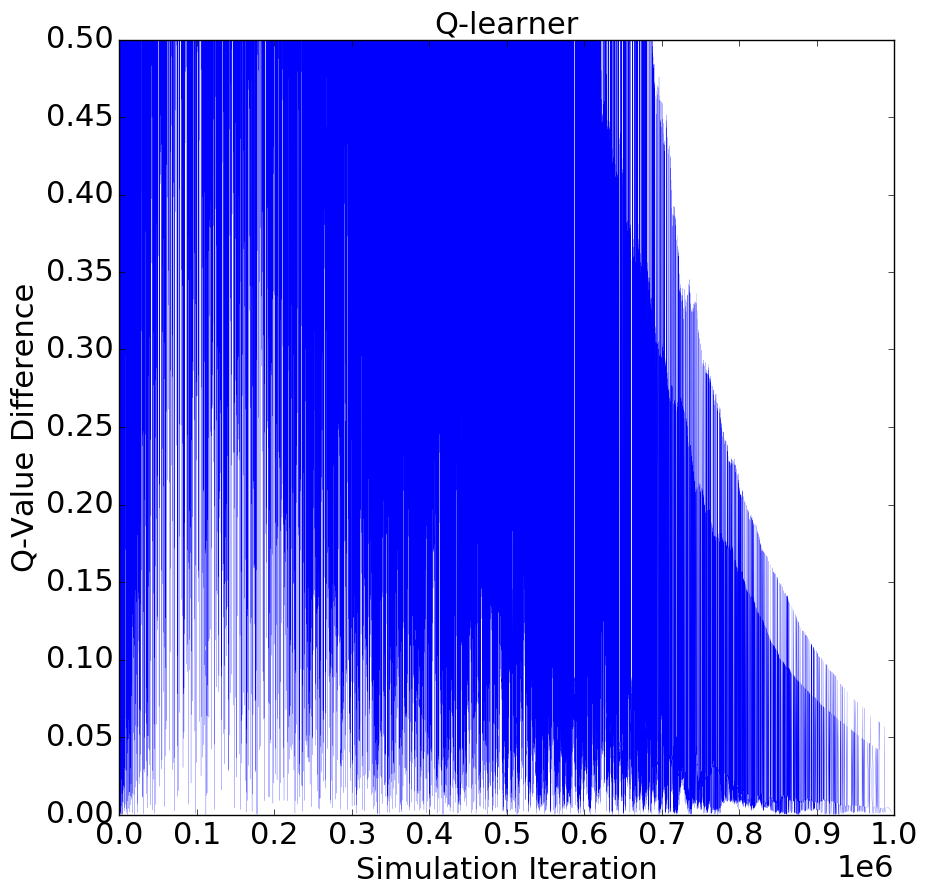

In [6]:
playerA = player(name="A")
playerB = player(name="B")
SOCCER_GAME = soccer_game(playerA, playerB)
err, iter = _Q_learning(SOCCER_GAME, playerA, playerB, iterations=10**6, epsilonMAX=0.90, epsilonMIN=0.001, alphaMAX=1.00, alphaMIN=0.001, gamma=0.9)
_graph(err, iter, "Q-learner", 0.1)

# Friend-Q

In [7]:
def _Friend_Q_learning(GAME, playerA, playerB, iterations, alphaMAX, alphaMIN, gamma):
    
    alpha_decay = 0.999993
    alpha = alphaMAX
    
    # Make Q-table
    Q_players = np.zeros([GAME.observation_space, GAME.action_space, GAME.action_space])
    
    GAME._reset()
    done = 0

    Q_error_list = []
    iteration_list = []
    
    for iteration in range(iterations):
        
        if done == 1:
            GAME._reset()
            done = 0
        
        current_state_index = GAME.states_hash[(playerA.pos, playerB.pos, GAME.ball)] 
        initial_state_index = GAME.states_hash[(2, 1, 1)] 
        old_Q_value = Q_players[initial_state_index, 1, 4] # State s in Figure4, A takes action S, B sticks
        
        # Random actions for player A and B
        actionA = np.random.choice(GAME.action_space)
        actionB = np.random.choice(GAME.action_space)
        
        # Take step
        next_state, rewardA, rewardB, done = GAME._step(playerA, playerB, actionA, actionB)
        next_state_index = GAME.states_hash[next_state]
        
        # Q-learning
        Q_players[current_state_index, actionA, actionB] += alpha * (rewardA + gamma * np.max(Q_players[next_state_index]) - Q_players[current_state_index, actionA, actionB])
        
        #Only calculate the Q error if the Q-value of State s and action S for A and sticking for B were changed
        if [current_state_index, actionA, actionB] == [initial_state_index, 1, 4]:
            Q_error_list.append(abs(Q_players[initial_state_index, 1, 4] - old_Q_value))
            iteration_list.append(iteration)
        
        # alpha decay
        if alpha > alphaMIN:
            alpha = alpha * alpha_decay
        
        # epsilon decay
        #if epsilon > epsilonMIN:
        #    epsilon = epsilon - epsilon_decay
        
        # print iteration
        if iteration % 50000 == 1:
            print("Now iteration: ", iteration)
        
    return Q_error_list, iteration_list

# Making Figure 3(c), Friend Q-learning

('Observation space: ', 112)
('Now iteration: ', 1)
('Now iteration: ', 50001)
('Now iteration: ', 100001)
('Now iteration: ', 150001)
('Now iteration: ', 200001)
('Now iteration: ', 250001)
('Now iteration: ', 300001)
('Now iteration: ', 350001)
('Now iteration: ', 400001)
('Now iteration: ', 450001)
('Now iteration: ', 500001)
('Now iteration: ', 550001)
('Now iteration: ', 600001)
('Now iteration: ', 650001)
('Now iteration: ', 700001)
('Now iteration: ', 750001)
('Now iteration: ', 800001)
('Now iteration: ', 850001)
('Now iteration: ', 900001)
('Now iteration: ', 950001)


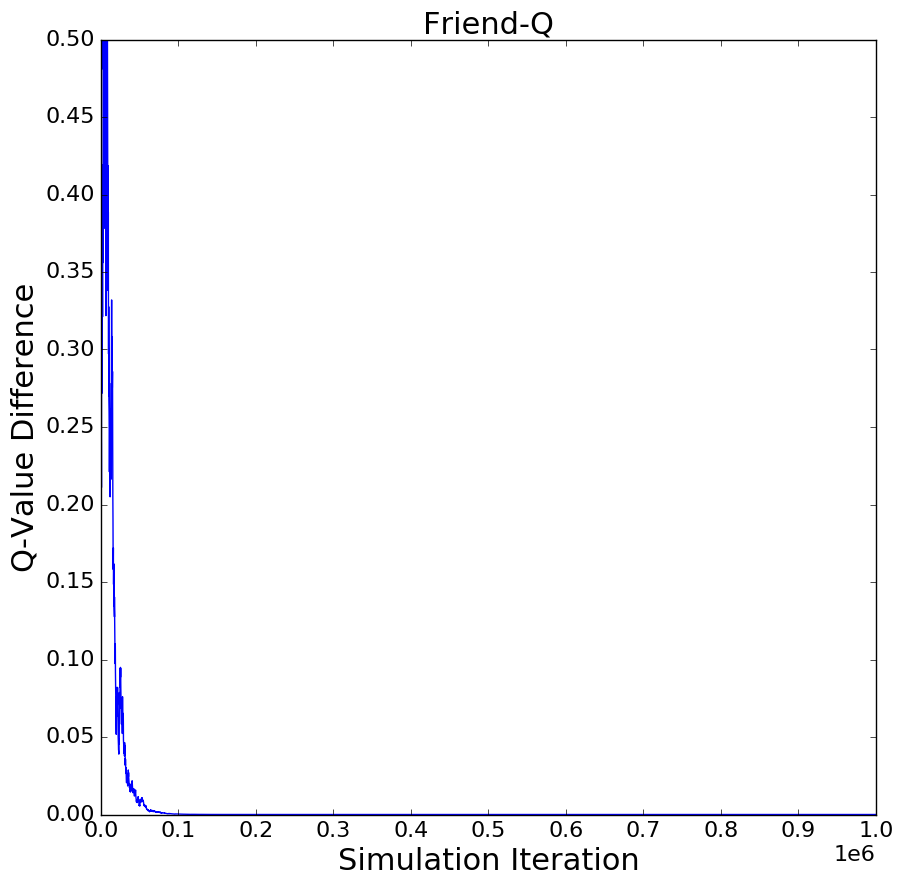

In [8]:
playerA = player(name="A")
playerB = player(name="B")
SOCCER_GAME = soccer_game(playerA, playerB)
err, iter = _Friend_Q_learning(SOCCER_GAME, playerA, playerB, iterations=10**6, alphaMAX=0.04, alphaMIN=0.001, gamma=0.9)
_graph(err, iter, "Friend-Q", 1)

# Foe-Q

In [9]:
def _minimax_solution(Q_table):
    
    Q = matrix(Q_table).trans()
    nrow = Q.size[0]
    ncol = Q.size[1]
    
    columnVector_ONE = np.ones((nrow, 1))
    columnVector_ZERO = np.zeros((nrow, 1))
    rowVector_ONE = np.ones(ncol)
    rowVector_ZERO = np.zeros(ncol)
    diagonalMatrix_ONE = np.eye(nrow)
    
    # Goal: Maximum payoff U
    # x = [U, 0, 1, 2, 3, 4]
    
    # Constraint 1: 
    # actions_prob = [p0, p1, p2, p3, p4]
    # actions_prob dot Q > U * columnVector1
    constraint1 = np.hstack((columnVector_ONE, Q))
    
    # Constraint 2
    # p0 > 0, p1 > 0, p2 > 0, p3 > 0, p4 > 0
    constraint2 = np.hstack((columnVector_ZERO, -diagonalMatrix_ONE))
    
    # Constraint 3
    # SUM(actions_prob) == 1
    constraint3 = np.vstack((np.hstack((0,rowVector_ONE)), np.hstack((0,-rowVector_ONE))))
    
    # Total constraint matrix
    A = matrix(np.vstack((constraint1, constraint2, constraint3)))
    
    # b Matrix
    b = matrix(np.hstack((np.zeros(nrow * 2), [1, -1])))
    
    # c Matrix
    c = matrix(np.hstack(([-1], rowVector_ZERO)))
    
    # solving lp
    solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF'}
    sol = solvers.lp(c,A,b, solver='glpk')
    
    if sol['primal objective']:
        return sol['primal objective']
    else:
        return 0.0

def _Foe_Q_learning(GAME, playerA, playerB, iterations, alphaMAX, alphaMIN, gamma):
    
    alpha_decay = 0.999993
    alpha = alphaMAX
    
    # Make Q-table
    Q_players = np.zeros([GAME.observation_space, GAME.action_space, GAME.action_space])
    
    GAME.new_game()
    done = 0

    Q_error_list = []
    iteration_list = []
    
    for iteration in range(iterations):
        
        if done == 1:
            GAME.new_game()
            done = 0
        
        current_state_index = GAME.states_hash[(playerA.pos, playerB.pos, GAME.ball)] 
        initial_state_index = GAME.states_hash[(2, 1, 1)] 
        current_Q_actions = Q_players[current_state_index]
        old_Q_value = Q_players[initial_state_index, 1, 4] # State s in Figure4, A takes action S, B sticks
        
        # Random actions for player A and B
        actionA = np.random.choice(GAME.action_space)
        actionB = np.random.choice(GAME.action_space)
        
        # Take step
        next_state, rewardA, rewardB, done = GAME._step(playerA, playerB, actionA, actionB)
        next_state_index = GAME.states_hash[next_state]
        next_Q_actions = Q_players[next_state_index]
        
        # Estimate the minimax payoff
        payoff = _minimax_solution(current_Q_actions)
        
        # Q-learning
        Q_players[current_state_index, actionA, actionB] += alpha * (rewardA + gamma * payoff - Q_players[current_state_index, actionA, actionB])
        
        #Only calculate the Q error if the Q-value of State s and action S for A and sticking for B were changed
        if [current_state_index, actionA, actionB] == [initial_state_index, 1, 4]:
            Q_error_list.append(abs(Q_players[current_state_index, 1, 4] - old_Q_value))
            iteration_list.append(iteration)
        
        # alpha decay
        if alpha > alphaMIN:
            alpha = alpha * alpha_decay
        
        # print iteration
        if iteration % 50000 == 1:
            print("Now iteration: ", iteration)
        
    return Q_error_list, iteration_list

# Making Figure 3(b), Foe Q-learning

('Observation space: ', 112)
('Now iteration: ', 1)
('Now iteration: ', 50001)
('Now iteration: ', 100001)
('Now iteration: ', 150001)
('Now iteration: ', 200001)
('Now iteration: ', 250001)
('Now iteration: ', 300001)
('Now iteration: ', 350001)
('Now iteration: ', 400001)
('Now iteration: ', 450001)
('Now iteration: ', 500001)
('Now iteration: ', 550001)
('Now iteration: ', 600001)
('Now iteration: ', 650001)
('Now iteration: ', 700001)
('Now iteration: ', 750001)
('Now iteration: ', 800001)
('Now iteration: ', 850001)
('Now iteration: ', 900001)
('Now iteration: ', 950001)


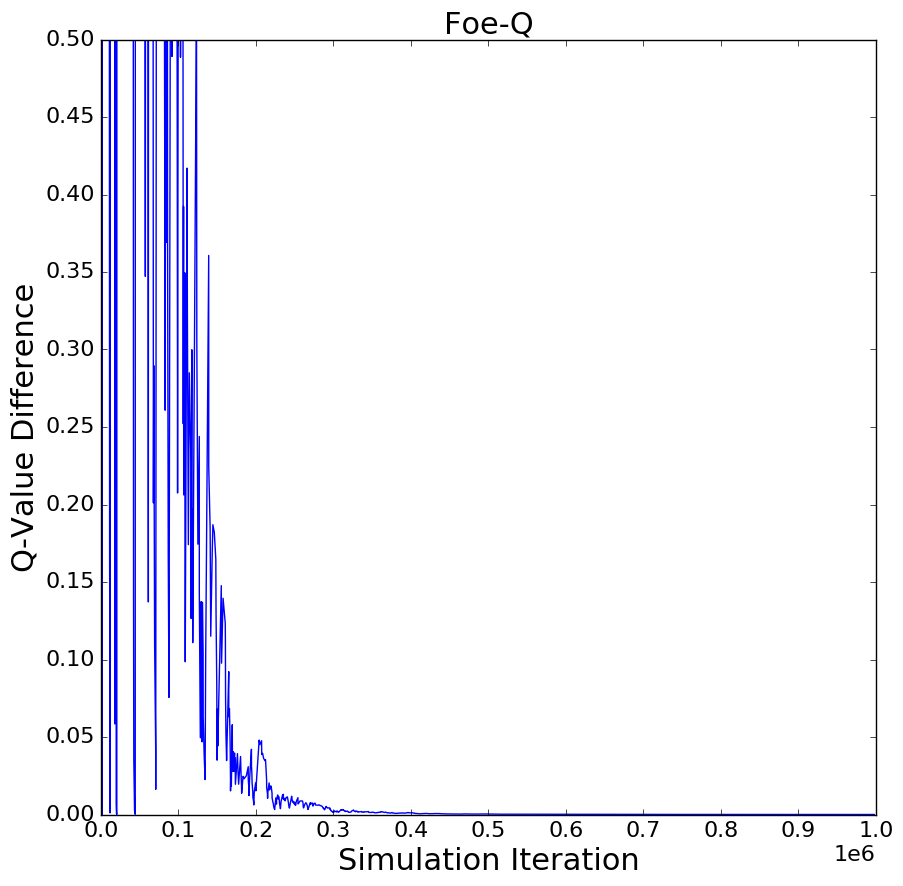

In [10]:
playerA = player(name="A")
playerB = player(name="B")
SOCCER_GAME = soccer_game(playerA, playerB)
err, iter = _Foe_Q_learning(SOCCER_GAME, playerA, playerB, iterations=10**6, alphaMAX=1.00, alphaMIN=0.001, gamma=0.9)
_graph(err, iter, "Foe-Q", 1)

# Correlated-Q

In [11]:
def _CE_solution(Q_table1, Q_table2):
    
    # 5 X 5 matrix for both Q_table1 and Q_table2
    Q_table1 = np.array(Q_table1)
    Q_table2 = np.array(Q_table2)
    ncol = Q_table1.shape[1]

    # zero-sum game, maximize the sum of the players' rewards
    # should total have 2 * 5 * (5-1) probability contraints, 5 * 5 joint probabilities
    Q = np.zeros((2*ncol*(ncol-1), (ncol*ncol)))
    rowIndex = 0
    
    # Building the inequality equations
    for actionA_index in range(ncol):
        for actionB_index in range(ncol):
            if actionA_index != actionB_index:
                Q[rowIndex, actionA_index*ncol:(actionA_index+1)*ncol] = \
                Q_table1[actionA_index] - Q_table1[actionB_index]
                Q[rowIndex+ncol*(ncol-1), actionA_index:(ncol*ncol):ncol] = \
                Q_table2[:,actionA_index] - Q_table2[:,actionB_index]
                rowIndex = rowIndex + 1
    
    # Building column and row vectors with all 1 and 0
    columnVector_ONE = np.ones((2 * ncol * (ncol - 1), 1))
    columnVector_ZERO = np.zeros((ncol * ncol, 1))
    rowVector_ONE = np.ones(ncol * ncol)
    diagonalMatrix_ONE = np.eye(ncol * ncol)
    
    # Sum of the players' rewards
    sumRewards = (Q_table1 + Q_table2).flatten()
    
    # Constraints
    constraint1 = np.hstack((columnVector_ONE, Q))
    constraint2 = np.hstack((columnVector_ZERO, -diagonalMatrix_ONE))
    constraint3 = np.vstack((np.hstack((0,rowVector_ONE)), np.hstack((0,-rowVector_ONE))))
    
    # Total constraint matrix
    A = matrix(np.vstack((constraint1, constraint2, constraint3)))
    
    # Create b matrix
    b = matrix(np.hstack((np.zeros(2*ncol*(ncol-1) + ncol*ncol), [1, -1])))

    # Create c matrix
    c = matrix(np.hstack(([-1.], -sumRewards)))
    
    # solving lp
    solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF'}
    sol = solvers.lp(c,A,b, solver='glpk')
    
    # Compute expected reward for playerA
    if sol['x']:
        # joint action rewards dot multiply joint actions probabilities
        return np.matmul(Q_table1.flatten(), sol['x'][1:])[0]
    else:
        return 0.0



In [12]:
def _CE_learning(GAME, playerA, playerB, iterations, alphaMAX, alphaMIN, gamma):
    
    alpha_decay = 0.999993
    alpha = alphaMAX
    
    # Make Q-tables
    Q_playerA = np.zeros([GAME.observation_space, GAME.action_space, GAME.action_space])
    Q_playerB = np.zeros([GAME.observation_space, GAME.action_space, GAME.action_space])
    
    GAME.new_game()
    done = 0

    Q_error_list = []
    iteration_list = []
    
    for iteration in range(iterations):
        
        if done == 1:
            GAME.new_game()
            done = 0
        
        current_state_index = GAME.states_hash[(playerA.pos, playerB.pos, GAME.ball)] 
        initial_state_index = GAME.states_hash[(2, 1, 1)] 
        current_Q_playerA = Q_playerA[current_state_index]
        current_Q_playerB = Q_playerB[current_state_index]
        old_Q_value = Q_playerA[initial_state_index, 1, 4] # State s in Figure4, A takes action S, B sticks
        
        # Random actions for player A and B
        actionA = np.random.choice(GAME.action_space)
        actionB = np.random.choice(GAME.action_space)
        
        # Take step
        next_state, rewardA, rewardB, done = GAME._step(playerA, playerB, actionA, actionB)
        next_state_index = GAME.states_hash[next_state]
        
        # Estimate the payoff for both players
        payoffA = _CE_solution(current_Q_playerA, current_Q_playerB)
        payoffB = -payoffA # zero-sum game
        
        # Q-learning
        Q_playerA[current_state_index, actionA, actionB] += alpha * (rewardA + gamma * payoffA - Q_playerA[current_state_index, actionA, actionB])
        Q_playerB[current_state_index, actionA, actionB] += alpha * (rewardB + gamma * payoffB - Q_playerB[current_state_index, actionA, actionB])
        
        #Only calculate the Q error if the Q-value of State s and action S for A and sticking for B were changed
        if [current_state_index, actionA, actionB] == [initial_state_index, 1, 4]:
            Q_error_list.append(abs(Q_playerA[current_state_index, 1, 4] - old_Q_value))
            iteration_list.append(iteration)
        
        # alpha decay
        if alpha > alphaMIN:
            alpha = alpha * alpha_decay
        
        # print iteration
        if iteration % 50000 == 1:
            print("Now iteration: ", iteration)
        
    return Q_error_list, iteration_list

# Making Figure 3(a), CE Q-learning

('Observation space: ', 112)
('Now iteration: ', 1)
('Now iteration: ', 50001)
('Now iteration: ', 100001)
('Now iteration: ', 150001)
('Now iteration: ', 200001)
('Now iteration: ', 250001)
('Now iteration: ', 300001)
('Now iteration: ', 350001)
('Now iteration: ', 400001)
('Now iteration: ', 450001)
('Now iteration: ', 500001)
('Now iteration: ', 550001)
('Now iteration: ', 600001)
('Now iteration: ', 650001)
('Now iteration: ', 700001)
('Now iteration: ', 750001)
('Now iteration: ', 800001)
('Now iteration: ', 850001)
('Now iteration: ', 900001)
('Now iteration: ', 950001)


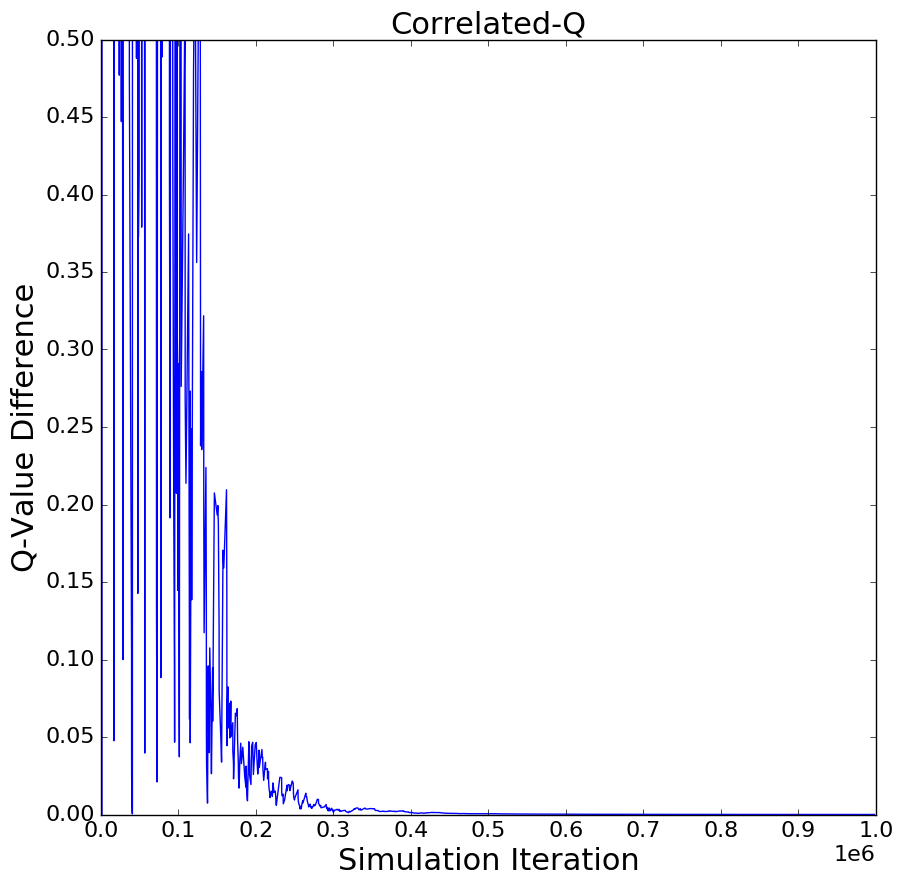

In [13]:
playerA = player(name="A")
playerB = player(name="B")
SOCCER_GAME = soccer_game(playerA, playerB)
err, iter = _CE_learning(SOCCER_GAME, playerA, playerB, iterations=10**6, alphaMAX=1.00, alphaMIN=0.001, gamma=0.9)
_graph(err, iter, "Correlated-Q", 1)